**Imports & Setup**

In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, applications, mixed_precision
from collections import Counter

In [15]:
TRAIN_DIR = Path("../../data/processed_balanced/train")
IMG_DIR = Path("../../data/processed")
VAL_DIR = IMG_DIR / "validate"
TEST_DIR = IMG_DIR / "test"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")
RESULTS_DIR = Path("./results")
RESULTS_PATH = RESULTS_DIR / "cnn_results.csv"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# target styles for classification
TARGET_STYLES = [
    "Abstract_Expressionism",
    "Baroque",
    "Cubism",
    "Impressionism",
    "Pop_Art"
]

RANDOM_SEED = 635

**Load Data & Normalize**

In [ ]:
# enabled for faster training
mixed_precision.set_global_policy("mixed_float16")

# config for data pipeline
IMG_SIZE = (224, 224)
BATCH = 128

def make_ds(root, training=False):
    '''
    build tf.data.Dataset from image paths & labels
    '''
    ds = tf.keras.utils.image_dataset_from_directory(root, labels="inferred", label_mode="int", class_names=TARGET_STYLES, image_size=IMG_SIZE, batch_size=BATCH, shuffle=training, seed=RANDOM_SEED)
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=tf.data.AUTOTUNE)
    opts = tf.data.Options()
    opts.experimental_deterministic = False
    ds = ds.with_options(opts)
    # prefetch & cache if not training (was causing hanging epochs)
    if training:
        return ds.prefetch(tf.data.AUTOTUNE)
    else:
        return ds.cache().prefetch(tf.data.AUTOTUNE)

# build datasets
train_ds = make_ds(TRAIN_DIR, training=True)
val_ds = make_ds(VAL_DIR, training=False)
test_ds = make_ds(TEST_DIR, training=False)


Found 15000 files belonging to 5 classes.
Found 4760 files belonging to 5 classes.
Found 4761 files belonging to 5 classes.


**Regularized CNN**

In [18]:
# data augmentation for training
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

# efficientnetb0 backbone (frozen for faster training)
base = applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
base.trainable = False

# building model
inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = augment(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(TARGET_STYLES), activation="softmax", dtype="float32")(x)
reg_cnn = models.Model(inputs, outputs, name="artstyle_fast")

# compile cnn
reg_cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# early stopping & reduce lr callbacks for accuracy/speed
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
# training with callbacks
history_reg = reg_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# save final weights
(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
reg_cnn.save_weights(RESULTS_DIR / "cnn_fast_final.weights.h5")


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1016s 9s/step - accuracy: 0.6613 - loss: 0.8824 - val_accuracy: 0.7985 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 933s 8s/step - accuracy: 0.7624 - loss: 0.6326 - val_accuracy: 0.8319 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 935s 8s/step - accuracy: 0.7833 - loss: 0.5743 - val_accuracy: 0.8431 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 937s 8s/step - accuracy: 0.7941 - loss: 0.5469 - val_accuracy: 0.8477 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 938s 8s/step - accuracy: 0.8045 - loss: 0.5224 - val_accuracy: 0.8525 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 952s 8s/step - accuracy: 0.8091 - loss: 0.5097 - val_accuracy: 0.8548 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 978s 8s/step - accuracy: 0.8145 - loss: 0

KeyboardInterrupt: 

**Export Results & Visuals**

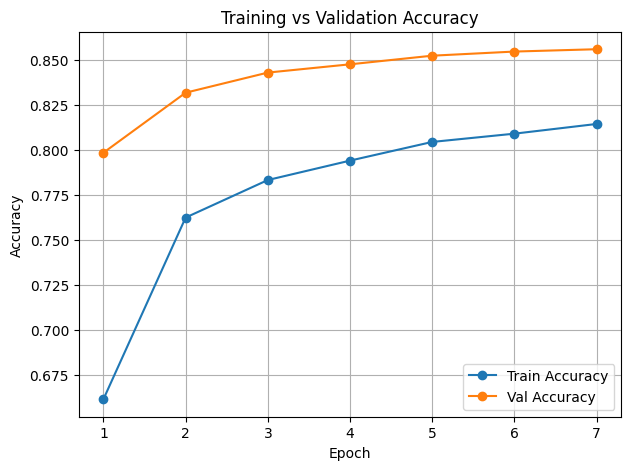

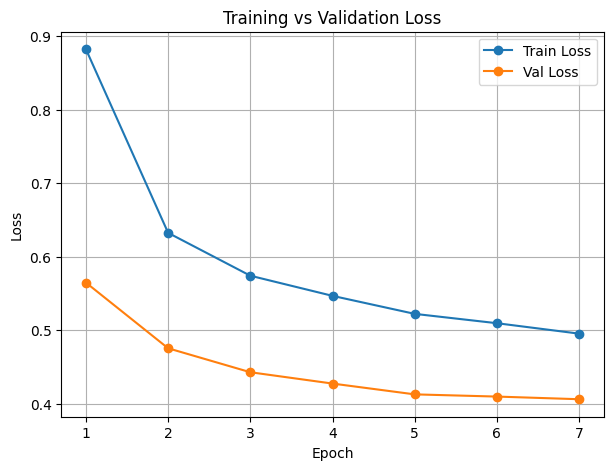

In [19]:
# load data
CSV_PATH = Path("./results/cnn_epoch_metrics.csv")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(CSV_PATH)

# get columns
cols = {c.lower(): c for c in df.columns}
def get_col(*options):
    for k in options:
        if k in cols:
            return cols[k]
ep_col = get_col("epoch")
acc_col = get_col("accuracy","acc","train_accuracy","training_accuracy")
val_acc = get_col("val_accuracy","validation_accuracy")
loss_col = get_col("loss","train_loss","training_loss")
val_loss = get_col("val_loss","validation_loss")

# create plot for accuracy & save directory
plt.figure(figsize=(7,5))
plt.plot(df[ep_col], df[acc_col], marker="o", label="Train Accuracy")
plt.plot(df[ep_col], df[val_acc], marker="o", label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()
acc_path = RESULTS_DIR / "cnn_train_val_accuracy.png"
plt.savefig(acc_path, bbox_inches="tight", dpi=150)
plt.show()

# create plot for loss & save directory
plt.figure(figsize=(7,5))
plt.plot(df[ep_col], df[loss_col], marker="o", label="Train Loss")
plt.plot(df[ep_col], df[val_loss], marker="o", label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
loss_path = RESULTS_DIR / "cnn_train_val_loss.png"
plt.savefig(loss_path, bbox_inches="tight", dpi=150)
plt.show()
